# Классификация рукописных цифр из базы MNIST с использованием нейронных сетей

Загружаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/). 

In [1]:
import codecs
import array
import struct
import os
import urllib
import gzip

import numpy as np

import matplotlib.pyplot as plt

In [2]:
from mnist import load_dataset

In [3]:
train_images, train_labels, test_images, test_labels = load_dataset()

In [4]:
print("Train size = %i, test_size = %i" % (len(train_images), len(test_images)))

Train size = 60000, test_size = 10000


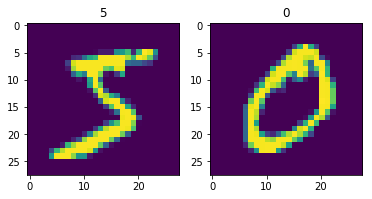

In [5]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(train_images[i].reshape([28, 28]))
    plt.title(str(train_labels[i]))

Переводим датасет из бинарного представления в формат numpy матрицы. 

In [6]:
n_train = len(train_labels)
n_test = len(test_labels)

Предобрабатываем получившуюся выборку:
 - приводим все входные признаки в интервал [0;1]
 - представляем метки классов с помощью one-hot encoding

In [7]:
import keras
from keras.models import Sequential                                    
from keras.layers import Dense, Activation, Dropout                   
from keras.optimizers import SGD                              
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


In [8]:
def preprocess(X, y):
    X = X.astype('float32').reshape(X.shape[0], X.shape[1] * X.shape[2])
    X /= 255
    y = to_categorical(y, 10)
    idxs = np.random.permutation(np.arange(X.shape[0]))
    return X[idxs,:],y[idxs,:]

In [9]:
train_images.shape

(60000, 1, 28, 28)

In [10]:
X_train, y_train = preprocess(np.squeeze(train_images), train_labels)
X_test, y_test = preprocess(np.squeeze(test_images), test_labels)
X_train.shape

(60000, 784)

Обучаем простую полносвязную сеть из двух слоев на базе MNIST. В качестве функции потерь будем использовать кросс-энтропию - обобщение логистической регрессии на случай нескольких классов.
Сеть будет обучаться с помошью стандартного стохастического градиентного спуска.

In [11]:
model = Sequential()

model.add(Dense(512, input_dim=len(X_train[0]), init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512, init='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, momentum=0.0, decay=0.0)
model.compile(loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=784, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="uniform")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="uniform")`
  if __name__ == '__main__':


In [12]:
!nvidia-smi

Thu Oct  3 15:36:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   37C    P8    15W / 200W |   7856MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   36C    P8    15W / 200W |   7856MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [13]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [ ]:
history = model.fit(X_train, y_train,
        nb_epoch=40,
        batch_size=128,
        verbose=1,
        validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, batch_size=128)
print(score)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 108us/step - loss: 2.3818 - acc: 0.1027 - val_loss: 2.4173 - val_acc: 0.0974
Epoch 2/40
60000/60000 [==============================] - 2s 38us/step - loss: 2.3872 - acc: 0.0979 - val_loss: 2.3609 - val_acc: 0.1009
Epoch 3/40
60000/60000 [==============================] - 2s 38us/step - loss: 2.3859 - acc: 0.1004 - val_loss: 2.3239 - val_acc: 0.1009
Epoch 4/40
60000/60000 [==============================] - 2s 38us/step - loss: 2.3730 - acc: 0.1007 - val_loss: 2.3710 - val_acc: 0.1135
Epoch 5/40
60000/60000 [==============================] - 2s 41us/step - loss: 2.3759 - acc: 0.1005 - val_loss: 2.4125 - val_acc: 0.0982
Epoch 6/40
60000/60000 [==============================] - 3s 42us/step - loss: 2.3726 - acc: 0.1014 - val_loss: 2.3533 - val_acc: 0.1135
Epoch 7/40
60000/60000 [==============================] - 3s 43us/step - loss: 2.3715 - acc: 0.1021 - val_loss: 2.4404 - val_ac

Строим графики обучения.

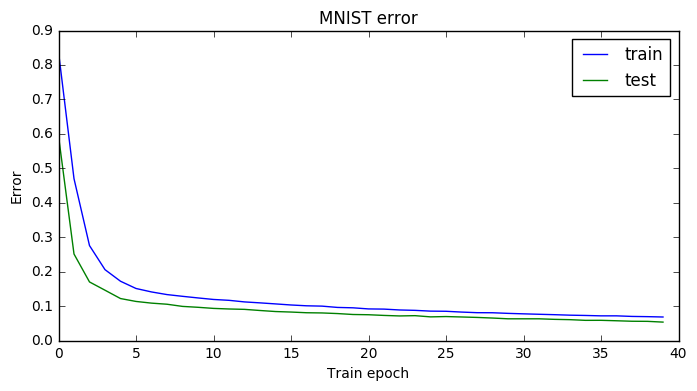

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

train_error = 1 - np.array(history.history['acc'])
val_error = 1 - np.array(history.history['val_acc'])

plt.figure(figsize=(8, 4))
plt.plot(train_error, label = 'train')
plt.plot(val_error, label = 'test')
plt.title('MNIST error')
plt.xlabel('Train epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
import sys
import os
import time

import numpy as np

__doc__="""taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
#     X_train, X_val = X_train[:-10000], X_train[-10000:]
#     y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_test, y_test